In [14]:
import numpy as np 

import pandas as pd
import matplotlib.pyplot as plt
                    

In [78]:
#добавление помех

def add_error(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    with open(file_path, 'w') as file:
        file.write(lines[0])  
        for line in lines[1:]:
            parts = line.split()  
            parts[3] = f"{float(parts[3]) + 5:.7f}"  
            modified_line = (
                '     ' + parts[0] + '    ' + parts[1] + '    ' + parts[2] + '    ' + parts[3] + '   ' + parts[4] +
                '   ' + parts[5] + '   ' + parts[6] + '  ' + parts[7] + '  ' + parts[8] + '   ' + parts[9] + '  ' + parts[10] +
                '  ' + parts[11] + '\n'
            ) 
            file.write(modified_line)  # Записываем измененную строку
None

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import jv #Функция Бесселя осредненная на периоде

In [80]:
class Calibration:
    def __init__(self, fit_intercept=True,amplitude = np.pi, period = 5):
        self.fit_intercept = fit_intercept
        self.amplitude = amplitude
        self.period = period
    def fit(self, X, Y_v_e,Y_v_n):
        
        X = np.reshape(X,newshape = (-1,1))
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)
        X_poly = np.delete(X_poly, 0, axis = 1)
        
        model_v_e = LinearRegression().fit(X_poly,Y_v_e)
        model_v_n = LinearRegression().fit(X_poly,Y_v_n)
        self.v_e_coef = model_v_e.coef_
        self.v_e_bias = model_v_e.intercept_
        self.v_n_coef = model_v_n.coef_
        self.v_n_bias = model_v_n.intercept_
    def v_e_predict(self,t):
        return np.dot(self.v_e_coef,np.array([t,t**2,t**3])) + self.v_e_bias

    def v_n_predict(self,t):
        return np.dot(self.v_n_coef,np.array([t,t**2,t**3])) + self.v_n_bias
    
    
    def a_e(self,t):
        derivative_coef = [self.v_e_coef[0], 2 * self.v_e_coef[1], 3 * self.v_e_coef[2]]

        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2] 

    def a_n(self,t):
        derivative_coef = [self.v_n_coef[0], 2 * self.v_n_coef[1], 3 * self.v_n_coef[2]]
    
        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2]

    def c(self):
        b = self.period * jv(1, self.amplitude)
        
        return 4 * b * (np.pi**2) / (self.period**2)

In [81]:
#константы
ins1 = pd.read_csv('experiments/vertical_axis/rotate_Y_period_5_amplitude_90/ins.nav', delim_whitespace=True,skiprows=1, header = None)
rotate_ax = 2
ind_start = 4000 
ind_end = 14000 - 1

v_e = ins1.iloc[ind_start:ind_end, 4].values
v_n = ins1.iloc[ind_start:ind_end, 5].values

#
clb1 = Calibration( period = 5,amplitude =np.pi/2 )
clb1.fit(ins1.iloc[ind_start:ind_end,0],v_e,v_n)

a_e1 = clb1.a_e(ins1.iloc[ind_start,0])
a_n1 = clb1.a_n(ins1.iloc[ind_start,0])

#
ins2 = pd.read_csv('experiments/vertical_axis/rotate_Y_period_10_amplitude_90/ins.nav', delim_whitespace=True,skiprows=1,header = None)

v_e = ins2.iloc[ind_start:ind_end, 4].values
v_n = ins2.iloc[ind_start:ind_end, 5].values
# 
clb2 = Calibration(period = 10, amplitude = np.pi/2)
clb2.fit(ins2.iloc[ind_start:ind_end,0],v_e,v_n)

a_e2 = clb2.a_e(ins2.iloc[ind_start,0])
a_n2 = clb2.a_n(ins2.iloc[ind_start,0])

None

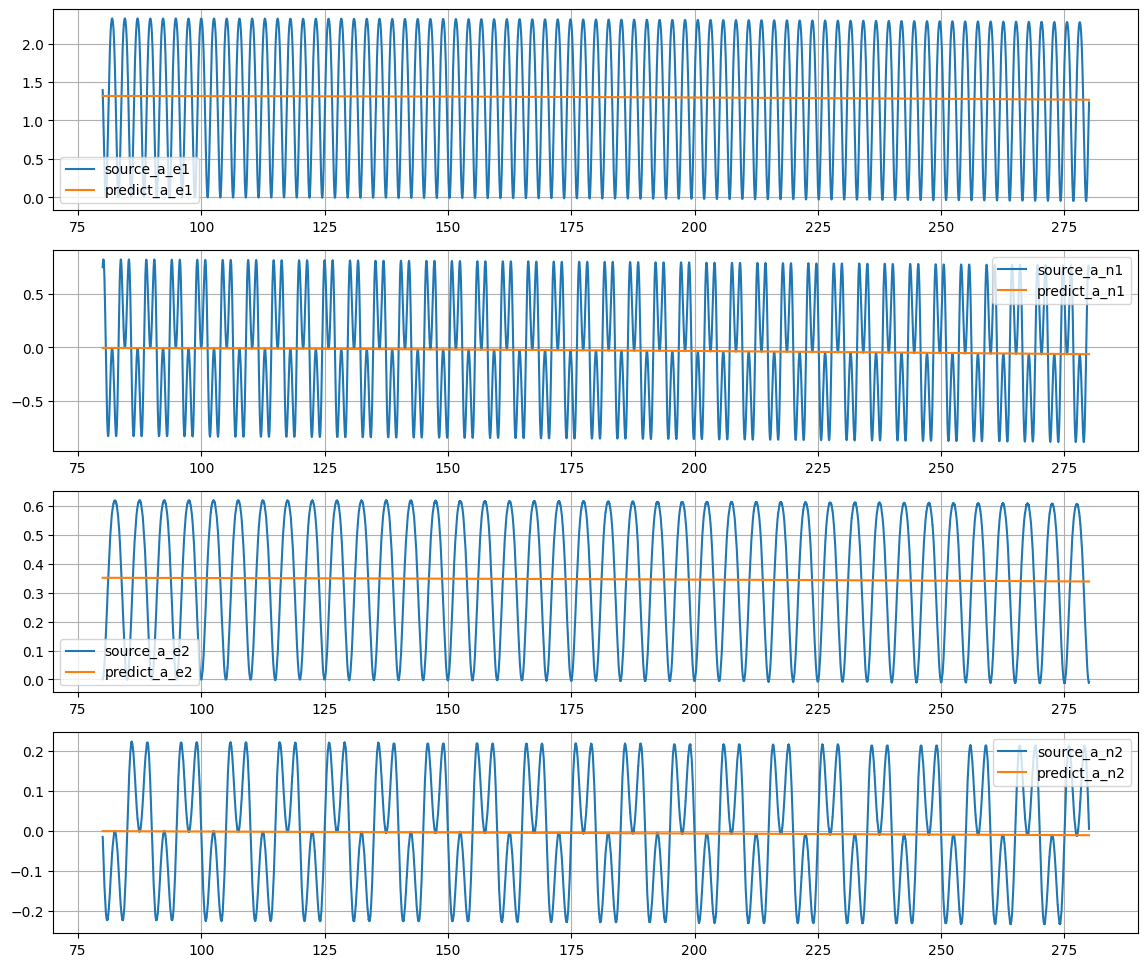

In [82]:
fig,axs = plt.subplots(4,1, figsize = (14,12))
a_e1_source = np.gradient(ins1.iloc[ind_start:ind_end, 4].values,0.02)
a_e1_predict = clb1.a_e(ins1.iloc[ind_start:ind_end,0])

a_n1_source = np.gradient(ins1.iloc[ind_start:ind_end, 5].values,0.02)
a_n1_predict = clb1.a_n(ins1.iloc[ind_start:ind_end,0])

axs[0].plot(ins1.iloc[ind_start:ind_end,0],a_e1_source, label = 'source_a_e1')
axs[0].plot(ins1.iloc[ind_start:ind_end,0],a_e1_predict, label = 'predict_a_e1')
axs[0].grid()
axs[0].legend()

axs[1].plot(ins1.iloc[ind_start:ind_end,0],a_n1_source, label = 'source_a_n1')
axs[1].plot(ins1.iloc[ind_start:ind_end,0],a_n1_predict, label = 'predict_a_n1')
axs[1].grid()
axs[1].legend()

a_e2_source = np.gradient(ins2.iloc[ind_start:ind_end, 4].values,0.02)
a_e2_predict = clb2.a_e(ins2.iloc[ind_start:ind_end,0])

a_n2_source = np.gradient(ins2.iloc[ind_start:ind_end, 5].values,0.02)
a_n2_predict = clb2.a_n(ins2.iloc[ind_start:ind_end,0])

axs[2].plot(ins2.iloc[ind_start:ind_end,0],a_e2_source, label = 'source_a_e2')
axs[2].grid()
axs[2].plot(ins2.iloc[ind_start:ind_end,0],a_e2_predict, label = 'predict_a_e2')
axs[2].legend()

axs[3].plot(ins2.iloc[ind_start:ind_end,0],a_n2_source, label = 'source_a_n2')
axs[3].grid()
axs[3].plot(ins2.iloc[ind_start:ind_end,0],a_n2_predict, label = 'predict_a_n2')
axs[3].legend()

In [84]:
mean_psi = ins.iloc[ind_start:ind_end,9].mean()
mean_psi = mean_psi*np.pi/180
if rotate_ax == 1:
    R_mat  = np.array([[-np.cos(mean_psi), np.sin(mean_psi)],
                  [-np.sin(mean_psi),  -np.cos(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_e2 - a_e1],
                            [a_n2 - a_n1]])) / (clb2.c() - clb1.c())
    r_zy = r[0]
    r_yz = r[1]
    print("[r_zy,r_yz] = ",r_zy,r_yz)
    
if rotate_ax == 2:
    R_mat = np.array([[np.cos(mean_psi), -np.sin(mean_psi)],
                  [np.sin(mean_psi),  np.cos(mean_psi)]])
  
    r = np.dot(R_mat, np.array([[a_e1 - a_e2 ],
                            [a_n1 - a_n2 ]])) / (clb1.c() - clb2.c())
    r_xz = r[0]
    r_zx = r[1]
    print("[r_xz, r_zx] = ",r_xz, r_zx)

if rotate_ax == 3:
    R_mat = R_mat = np.array([[np.sin(mean_psi), -np.cos(mean_psi)],
                  [np.cos(mean_psi),  np.sin(mean_psi)]])
    r = np.dot(R_mat, np.array([[a_e2 - a_e1],
                            [a_n2 - a_n1]])) / (clb2.c() - clb1.c())
    r_yx = r[0]
    r_xy = r[1]

    print("[r_yx,r_xy] = ",r_yx,r_xy)
    


None

[r_xz, r_zx] =  [0.43180438] [-0.00151299]


6.123233995736766e-17

# Визуализация

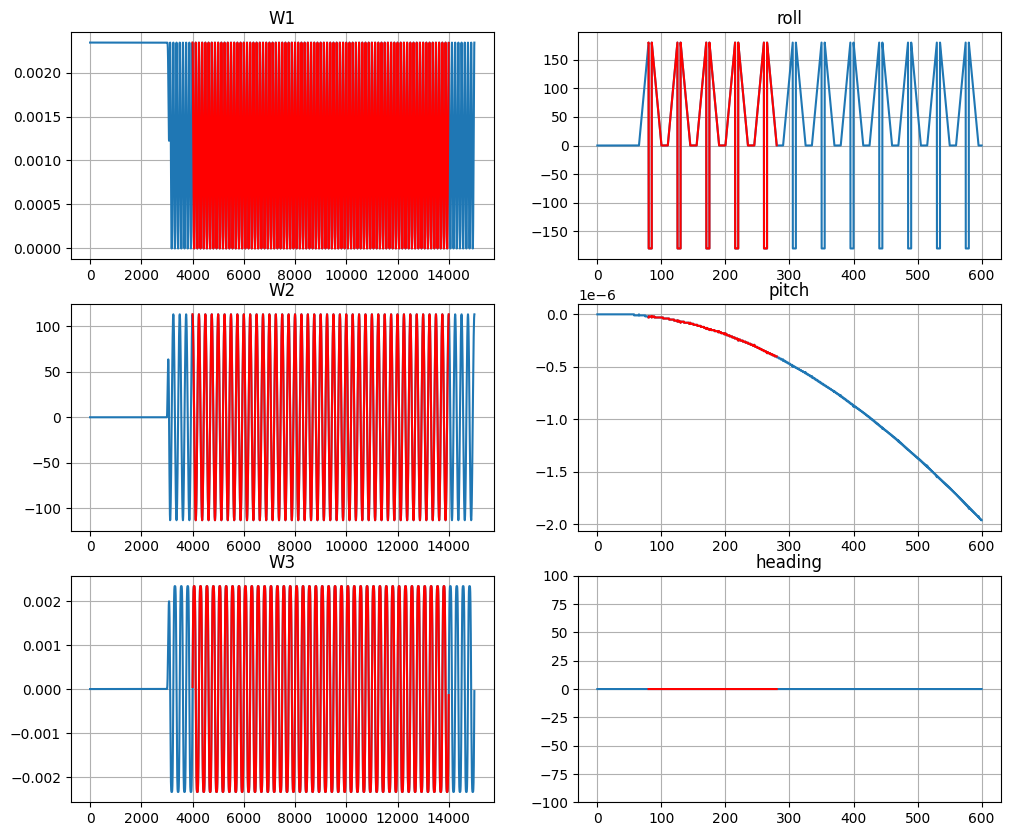

In [93]:
ind_start = 4000 
ind_end = 14000 - 1

fig1, axs1 = plt.subplots(3,2, figsize = (12,10))

axs1[0,0].plot(imu.iloc[:,0])
axs1[0,0].plot(imu.iloc[ind_start:ind_end,0],color = 'red')
axs1[0,0].grid()
axs1[0,0].title.set_text("W1")

axs1[1,0].plot(imu.iloc[:,1])
axs1[1,0].plot(imu.iloc[ind_start:ind_end,1],color = 'red')
axs1[1,0].grid()
axs1[1,0].title.set_text("W2")

axs1[2,0].plot(imu.iloc[:,2])
axs1[2,0].plot(imu.iloc[ind_start:ind_end,2],color = 'red')
axs1[2,0].grid()
axs1[2,0].title.set_text("W3")

#Курс, крен, тангаж
axs1[0,1].plot(ins.iloc[:,0],ins.iloc[:,7])
axs1[0,1].plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,7],color = 'red')
axs1[0,1].grid()
axs1[0,1].title.set_text("roll")

axs1[1,1].plot(ins.iloc[:,0],ins.iloc[:,8])
axs1[1,1].plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,8],color = 'red')
axs1[1,1].grid()
axs1[1,1].title.set_text("pitch")

axs1[2,1].plot(ins.iloc[:,0], ins.iloc[:,9] )
axs1[2,1].plot(ins.iloc[ind_start:ind_end,0], ins.iloc[ind_start:ind_end,9],color = 'red' )
axs1[2,1].grid()
axs1[2,1].title.set_text("heading")
axs1[2,1].set_ylim(-100,100)


None

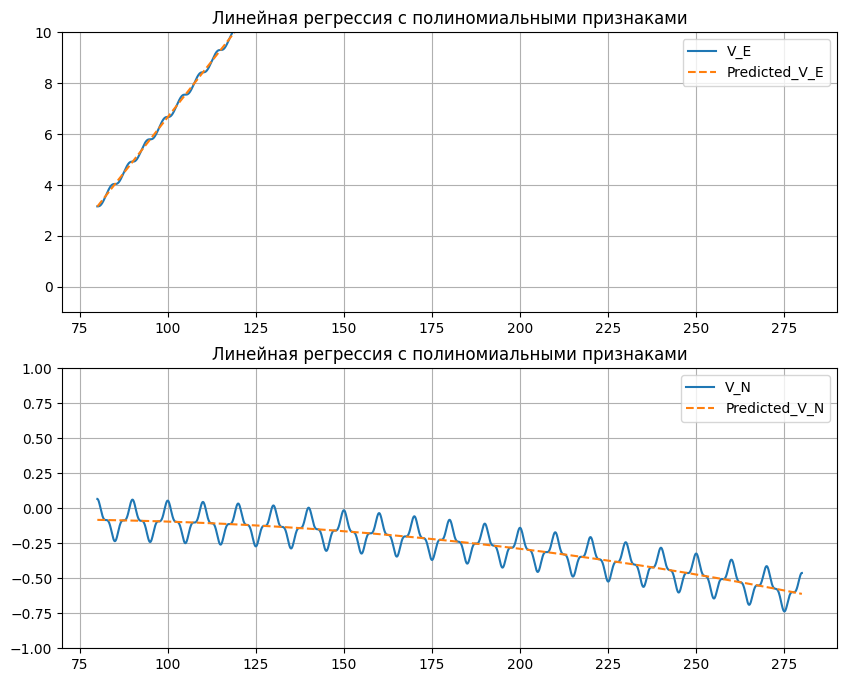

In [10]:
fig,axs = plt.subplots(2,1, figsize = (10,8))
axs[0].plot(ins.iloc[ind_start:ind_end, 0], v_e, label='V_E')
#axs[0].plot(ins.iloc[ind_start:ind_end, 0], a_e(ins.iloc[ind_start:ind_end, 0].values),label = "a_e")
axs[0].plot(ins.iloc[ind_start:ind_end, 0], clb2.v_e_predict(ins.iloc[ind_start:ind_end, 0]), label='Predicted_V_E', linestyle='--')
axs[0].set_title('Линейная регрессия с полиномиальными признаками')
axs[0].legend()
axs[0].set_ylim(-1,10)
#axs[0].set_xlim(80,85)
axs[0].grid()

axs[1].plot(ins.iloc[ind_start:ind_end, 0], v_n, label='V_N')
axs[1].plot(ins.iloc[ind_start:ind_end, 0], clb2.v_n_predict(ins.iloc[ind_start:ind_end, 0]), label='Predicted_V_N', linestyle='--')
#axs[1].plot(ins.iloc[ind_start:ind_end, 0],a_n(ins.iloc[ind_start : ind_end, 0]),label = "a_n")
axs[1].set_title('Линейная регрессия с полиномиальными признаками')
axs[1].legend()
axs[1].set_ylim(-1,1)
#axs[1].set_xlim(0,300)
axs[1].grid()

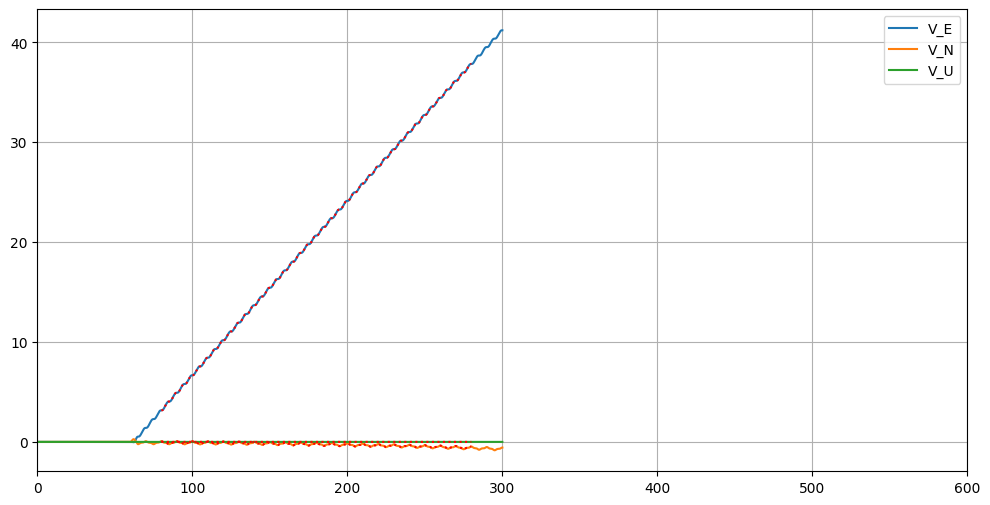

In [11]:
#График скороксти V_E и V_N
fig, axs = plt.subplots(1,1 ,figsize = (12,6))
axs.plot(ins.iloc[:,0],ins.iloc[:,4])
axs.plot(ins.iloc[:,0],ins.iloc[:,5])
axs.plot(ins.iloc[:,0],ins.iloc[:,6])
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,4],linestyle = "dotted",color = "red")
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,5],linestyle = "dotted",color = "red")
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,6],linestyle = "dotted",color = "red")

axs.legend(['V_E','V_N','V_U'])

axs.grid()
axs.set_xlim(0,600)
#axs.set_ylim(0,)

None

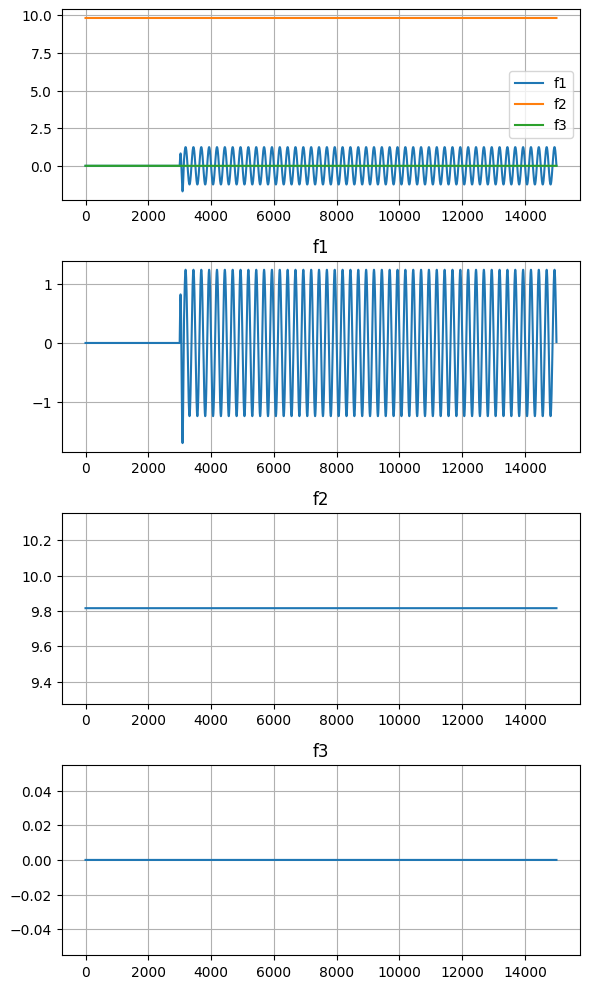

In [12]:

# График показаний акселерометров 
fig, axs = plt.subplots(4,1, figsize = (6,10))
axs[0].plot(imu.iloc[:,3],label ="f1")
axs[0].plot(imu.iloc[:,4],label ="f2")
axs[0].plot(imu.iloc[:,5],label ="f3")
axs[0].grid()
axs[0].legend()

axs[1].plot(imu.iloc[:,3])
axs[1].title.set_text("f1")
axs[1].grid()

axs[2].plot(imu.iloc[:,4])
axs[2].title.set_text("f2")
axs[2].grid()

axs[3].plot(imu.iloc[:,5])
axs[3].title.set_text("f3")
axs[3].grid()

plt.tight_layout()
plt.show()


# Оценка разнесений для реального БИНС

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
                    

In [14]:

#Config----
Amplitude = 90 #degree 
period = 60    #s
const_time = 10#s сумарное время стояния
accel_time = 2 #s сумарное время разгона
Om_0 = 5       # degree/s  
Eps = 10       # degree/s^2



G = np.array([[1, 2, 3],
     [6, 1, 4],
     [7, 2, 5]])

U, S, V = np.linalg.svd(G)
G = U

P_k =np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]) 

z = np.random.rand(3,1)*100

#----------


In [15]:
def Q_i(P_k,g_i):
    A = np.dot(P_k.T, g_i)
    return np.dot(A,A.T)


K = np.zeros((3,3,3))
F = np.dot(P_k.T,G.T)
for i in range(3):
    g_i = (G[i,:])
    g_i = g_i.reshape(-1, 1)
    Q = Q_i(P_k,g_i)
    A1 = np.array([[0,   0     ,  0     ],
                   [ 0, -Q[2,2],  Q[2,1]],
                   [ 0,  Q[1,2], -Q[1,1]] ]) 
    A1[1:3] = A1[1:3]*4*np.sin(Amplitude)*Om_0/period

    A2 = np.array([[0, -Q[0,1], -Q[0,2] ],
                   [0, -Q[1,1], -Q[1,2] ],
                   [0, -Q[2,1], -Q[2,2] ] ])
    A2[0] = A2[0] * (Om_0**2) * (period - const_time) / period
    A2[1:3] =  A2[1:3] * (Om_0**2) * accel_time * np.cos(Amplitude) / period
    K[i,:,:] = np.dot(A1 + A2, F)    



H = np.concatenate((K[0, :, 1].reshape(-1, 1),
                     K[0, :, 2].reshape(-1, 1),
                     K[1, :, 0].reshape(-1, 1),
                     K[1, :, 2].reshape(-1, 1),
                     K[2, :, 0].reshape(-1, 1),
                     K[2, :, 1].reshape(-1, 1)), axis=1)


inv = np.linalg.pinv(H)

x =np.dot(inv,z)  

print(x)

#[r_xy, r_xz, r_yx, r_yz, r_xz, r_zy]

[[  16.71692561]
 [-168.17168464]
 [-183.60058919]
 [ 132.60193252]
 [-179.54463928]
 [  28.7325845 ]]


## Горизонтальная ось вращения

In [96]:
class Calibration:
    def __init__(self, fit_intercept=True,amplitude = np.pi/2, period = 5):
        self.fit_intercept = fit_intercept
        self.amplitude = amplitude
        self.period = period
    def fit(self, X, v1,v2):
        
        X = np.reshape(X,newshape = (-1,1))
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)
        X_poly = np.delete(X_poly, 0, axis = 1)
        
        model_v1 = LinearRegression().fit(X_poly,v1)
        model_v2 = LinearRegression().fit(X_poly,v2)
        self.v1_coef = model_v1.coef_
        self.v1_bias = model_v1.intercept_
        self.v2_coef = model_v2.coef_
        self.v2_bias = model_v2.intercept_
    def v1_predict(self,t):
        return np.dot(self.v1_coef,np.array([t,t**2,t**3])) + self.v1_bias

    def v2_predict(self,t):
        return np.dot(self.v2_coef,np.array([t,t**2,t**3])) + self.v2_bias
    
    
    def a1(self,t):
        derivative_coef = [self.v1_coef[0], 2 * self.v1_coef[1], 3 * self.v1_coef[2]]

        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2] 

    def a2(self,t):
        derivative_coef = [self.v2_coef[0], 2 * self.v2_coef[1], 3 * self.v2_coef[2]]
    
        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2]

    def c_meandr(self):
        return 16 * self.amplitude * np.sin(self.amplitude) / (self.period**2)
    
    def c_sin(self):
        b = self.period * jv(1, self.amplitude)
        
        return 4 * b * (np.pi**2) / (self.period**2)

In [97]:
#константы
ins = pd.read_csv('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_35/ins.nav', delim_whitespace=True,skiprows=1)
rotate_ax = 1
ind_start = 4000 
ind_end = 14000 - 1
amplitude = np.pi/2

v1 = ins.iloc[ind_start:ind_end, 4].values
v3 = ins.iloc[ind_start:ind_end, 6].values

#
clb1 = Calibration( period = 35,amplitude = np.pi/2 )
clb1.fit(ins.iloc[ind_start:ind_end,0],v1,v3)

a_perpend1 = clb1.a1(ins.iloc[ind_start,0])
a_vertical1 = clb1.a2(ins.iloc[ind_start,0])

#
ins = pd.read_csv('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_45/ins.nav', delim_whitespace=True,skiprows=1)

v1 = ins.iloc[ind_start:ind_end, 4].values
v3 = ins.iloc[ind_start:ind_end, 6].values
# 
clb2 = Calibration(period = 45, amplitude= np.pi/2)
clb2.fit(ins.iloc[ind_start:ind_end,0],v1,v3)

a_perpend2 = clb2.a1(ins.iloc[ind_start,0])
a_vertical2 = clb2.a2(ins.iloc[ind_start,0])
print("a_e2,a_n2 = ",a_e2,a_n2)

None

a_e2,a_n2 =  0.3523016525004557 -0.0007805555539213325
clb1.c =  0.020516523452014976
clb2.c =  0.01241123023640412


In [102]:
mean_psi = (ins.iloc[ind_start:ind_end,7].mean())*np.pi/180
if rotate_ax == 1:
    #первая и вторая строчка поменяны местами 
    R_mat = np.array([[-np.cos(mean_psi), np.sin(mean_psi)],
                     [-np.sin(mean_psi),  -np.cos(mean_psi)]])
    

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c_meandr() - clb1.c_meandr())
    r_zy = r[0]
    r_yz = r[1]
    print("[r_zy,r_yz] = ",r_zy,r_yz)
    
if rotate_ax == 2:
    R_mat = np.array([[np.sin(mean_psi),  np.cos(mean_psi)],
                       [np.cos(mean_psi), -np.sin(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c_meandr() - clb1.c_meandr())
    
    r = np.dot(R_mat, np.array([[a_vertical1 ],
                            [a_perpend1 ]])) / ( clb1.c_meandr())
    
    
    r_xz = r[0]
    r_zx = r[1]
    print("[r_xz, r_zx] = ",r_xz, r_zx)

if rotate_ax == 3:
    R_mat = R_mat = np.array([[np.sin(mean_psi), -np.cos(mean_psi)],
                  [np.cos(mean_psi),  np.sin(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c_meandr() - clb1.c_meandr())
    
    r_yx = r[0]
    r_xy = r[1]

    print("[r_yx,r_xy] = ",r_yx,r_xy)
    


None

[r_zy,r_yz] =  [0.26442621] [-0.32890263]
